# Pneumonia_X-ray
## 폐렴 진단기 성능개선

### Step 1. 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel/aiffel


### Step 2. 데이터 준비하기
 - 의료영상 이미지의 특성상 데이터 충분히 않아 Augmentation 기법을 고려해볼만하지만... 
 - 하지만 의료영상은 위치나 미묘한 차이에 더해진 노이즈등 부수효과가 오히려 방해를 주므로 신중해야함!!

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))


Normal images count in training set: 1089
Pneumonia images count in training set: 3096


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [ ]:
# 좌우반전 정도의 Augmentation만 도입 해보자.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)


624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step3. 데이터 시각화

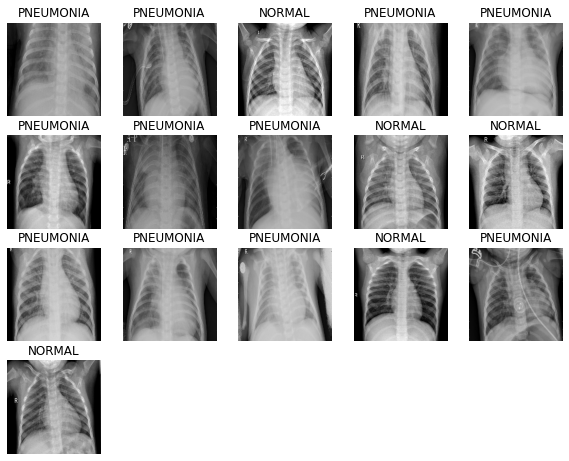

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN 모델링
 - Convolution filter, 채널개수, activation, 모델구조를 함수를 통해 구성
 - 특이하게 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성 (보통은 둘중 하나만 사용)
 - 이미지 사이즈가 크고 데이터가 부족한 의료영상에서 실용적으로 간혹 좋은 성능을 보인다고 함.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리 
 - 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나눠진 class_weight 설정

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


### Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 30s 116ms/step - loss: 0.4194 - accuracy: 0.7998 - precision: 0.9469 - recall: 0.7728 - val_loss: 0.6674 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2383 - accuracy: 0.9064 - precision: 0.9710 - recall: 0.9004 - val_loss: 1.2025 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2227 - accuracy: 0.9179 - precision: 0.9708 - recall: 0.9163 - val_loss: 0.1264 - val_accuracy: 0.9606 - val_precision: 0.9556 - val_recall: 0.9936
Epoch 4/25
261/261 [==============================] - 25s 98ms/step - loss: 0.1779 - accuracy: 0.9332 - precision: 0.9783 - recall: 0.9305 - val_loss: 0.5980 - val_accuracy: 0.7923 - val_precision: 1.0000 - val_recall: 0.7231
Epoch 5/25
261/261 [==============================] - 26s 98ms/step - loss: 0.1884 - accuracy

### Step 7. 결과 확인과 시각화

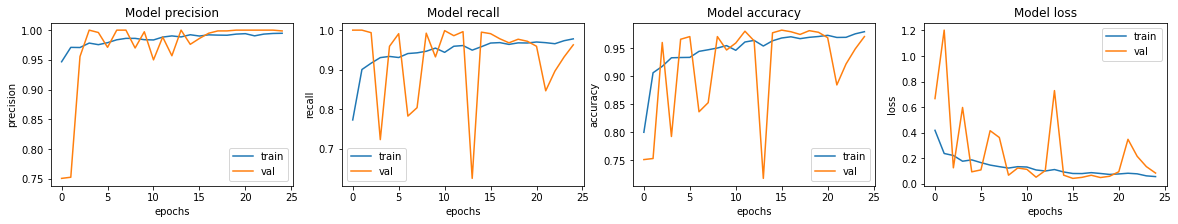

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 66ms/step - loss: 0.7431 - accuracy: 0.8702 - precision: 0.8411 - recall: 0.9769


# 루브릭
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
 - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
 - regularization, augmentation등의 기법의 사용여부에 따른 모델 성능측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
 - Accuracy 기준 85%에 도달하였다.


# 결과
 - 좌우반전 Augmentation을 도입하여 데이터를 증대해봤지만 오히려 성능이 낮아졌음
 - 이미지 사이즈를 180*180 에서 360*360으로 증대해봤지만 오히려 성능이 낮아졌음
 - 데이터 자체가 imbalance하고 데이터량이 적기 때문에 Training 데이터에서 무작위로 들어가는데 있어 성능의 편차가 심한것으로 판단됨.
 - BatchNomalization을 제외한 경우 성능이 60%대로 떨어지고 Dropout을 제외한 경우 80%대가 나오는걸 통해 BatchNorm의 성능향상이 더 큰것으로 판단됨
 - 기본 노드에서 제공되는 모델의 구조와 하이퍼파라미터로 85% 이상의 성능은 나왔지만 근본적으로 imbalnce데이터에 대한 문제를 해결해야 성능향상이 되고 정량적 판단이 될 수 있을것으로 생각됨.